In [10]:
import kagglehub

In [11]:
# Download customer-personality-analysis dataset
customer_path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")

print("Path to dataset files:", customer_path)

Using Colab cache for faster access to the 'customer-personality-analysis' dataset.
Path to dataset files: /kaggle/input/customer-personality-analysis


In [12]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [13]:
# columns in customer-personality-analysis dataset
# People
# ID: Customer's unique identifier
# Year_Birth: Customer's birth year
# Education: Customer's education level
# Marital_Status: Customer's marital status
# Income: Customer's yearly household income
# Kidhome: Number of children in customer's household
# Teenhome: Number of teenagers in customer's household
# Dt_Customer: Date of customer's enrollment with the company
# Recency: Number of days since customer's last purchase
# Complain: 1 if the customer complained in the last 2 years, 0 otherwise

# Products
# MntWines: Amount spent on wine in last 2 years
# MntFruits: Amount spent on fruits in last 2 years
# MntMeatProducts: Amount spent on meat in last 2 years
# MntFishProducts: Amount spent on fish in last 2 years
# MntSweetProducts: Amount spent on sweets in last 2 years
# MntGoldProds: Amount spent on gold in last 2 years

# Promotion
# NumDealsPurchases: Number of purchases made with a discount
# AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
# AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
# AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
# AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
# AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
# Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

# Place
# NumWebPurchases: Number of purchases made through the company’s website
# NumCatalogPurchases: Number of purchases made using a catalogue
# NumStorePurchases: Number of purchases made directly in stores
# NumWebVisitsMonth: Number of visits to company’s website in the last month

customer_data_file = customer_path + "/marketing_campaign.csv"
customer_df = pd.read_csv(customer_data_file, sep="\t")
print("Shape:", customer_df.shape)
customer_df.head(10)

Shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


In [14]:

# drop missing value
customer_df = customer_df.dropna()
# process date and time
customer_df['Dt_Customer'] = pd.to_datetime(customer_df['Dt_Customer'], dayfirst=True)
customer_df['Age'] = 2025 - customer_df['Year_Birth']
customer_df['Customer_days'] = (pd.to_datetime('2025-11-15') - customer_df['Dt_Customer']).dt.days
# encode categorical vars
education_order = ['Basic', 'Graduation', 'Master', '2n Cycle', 'PhD']
value_to_code = {value: i for i, value in enumerate(education_order)}
customer_df['education_encoded'] = customer_df['Education'].map(value_to_code)
mapping = lambda x: 0 if x in ['Together', 'Married'] else 1
customer_df['alone_encoded'] = customer_df['Marital_Status'].apply(mapping)
# sum
customer_df['num_child'] = customer_df['Kidhome'] + customer_df['Teenhome']
customer_df['spend'] = customer_df['MntFishProducts'] + customer_df['MntFruits'] + customer_df['MntGoldProds'] + customer_df['MntWines'] + customer_df['MntMeatProducts'] + customer_df['MntSweetProducts']
customer_df['num_cmp_accepted'] = customer_df['AcceptedCmp1'] + customer_df['AcceptedCmp2'] + customer_df['AcceptedCmp3'] + customer_df['AcceptedCmp4'] + customer_df['AcceptedCmp5'] + customer_df['Response']
# drop columns
customer_df_encoded = customer_df.drop(columns=['Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'ID', 'Marital_Status', 'Education', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome', 'MntFishProducts', 'MntFruits', 'MntGoldProds', 'MntWines', 'MntMeatProducts', 'MntSweetProducts'])

In [15]:
display(customer_df_encoded.describe().T)

,count,mean,std,min,25%,50%,75%,max
Income,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.0,666666.0
Recency,2216.0,49.012635,28.948352,0.0,24.0,49.0,74.0,99.0
NumDealsPurchases,2216.0,2.323556,1.923716,0.0,1.0,2.0,3.0,15.0
NumWebPurchases,2216.0,4.085289,2.740951,0.0,2.0,4.0,6.0,27.0
NumCatalogPurchases,2216.0,2.671029,2.926734,0.0,0.0,2.0,4.0,28.0
NumStorePurchases,2216.0,5.800993,3.250785,0.0,3.0,5.0,8.0,13.0
Complain,2216.0,0.009477,0.096907,0.0,0.0,0.0,0.0,1.0
Age,2216.0,56.179603,11.985554,29.0,48.0,55.0,66.0,132.0
Customer_days,2216.0,4510.521209,202.434667,4157.0,4337.0,4512.5,4686.0,4856.0
education_encoded,2216.0,1.972022,1.248795,0.0,1.0,1.0,3.0,4.0


In [16]:
customer_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2216 non-null   float64
 1   Recency              2216 non-null   int64  
 2   NumDealsPurchases    2216 non-null   int64  
 3   NumWebPurchases      2216 non-null   int64  
 4   NumCatalogPurchases  2216 non-null   int64  
 5   NumStorePurchases    2216 non-null   int64  
 6   Complain             2216 non-null   int64  
 7   Age                  2216 non-null   int64  
 8   Customer_days        2216 non-null   int64  
 9   education_encoded    2216 non-null   int64  
 10  alone_encoded        2216 non-null   int64  
 11  num_child            2216 non-null   int64  
 12  spend                2216 non-null   int64  
 13  num_cmp_accepted     2216 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 259.7 KB


In [17]:
X, y = customer_df_encoded.drop('spend', axis=1), customer_df_encoded['spend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# init model
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=2,
    n_jobs=-1,         # parallel traning
    random_state=42
)

In [19]:
import time

In [20]:
start_time = time.time()
# train
rf.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"training_time: {training_time:.2f} sec")

training_time: 0.73 sec


In [21]:
# predict
y_pred = rf.predict(X_test)

# feature_importances
feature_importance = dict(zip(X.columns, rf.feature_importances_))

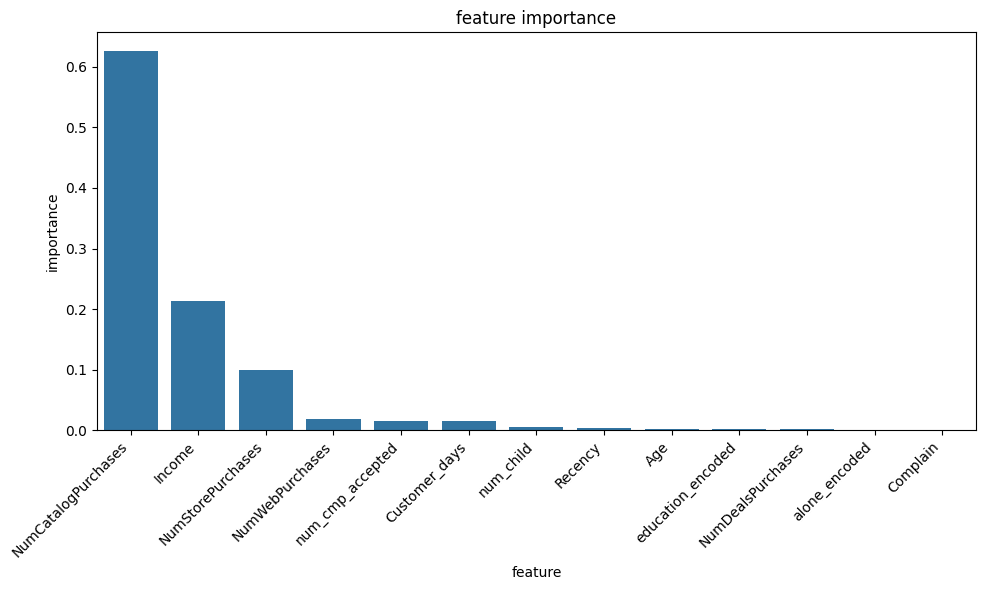

In [23]:
# plot feature_importances
import seaborn as sns
feat_imp_df = pd.DataFrame({
    'Feature': feature_importance.keys(),
    'Importance': feature_importance.values()
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=feat_imp_df)
plt.title('feature importance')
plt.xlabel('feature')
plt.ylabel('importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [25]:
# errors：MSE、R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}, R²: {r2:.4f}, RMSE: {rmse:.4f}, mae: {mae:.4f}")

MSE: 48023.9007, R²: 0.8732, RMSE: 219.1436, mae: 132.6047


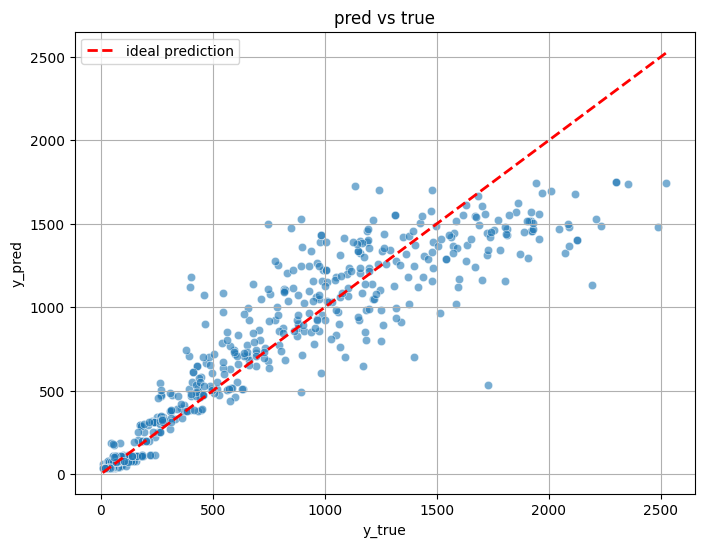

In [26]:

# plot pred vs true
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='ideal prediction')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('pred vs true')
plt.legend()
plt.grid(True)
plt.show()